Paquetes necesarios

In [166]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



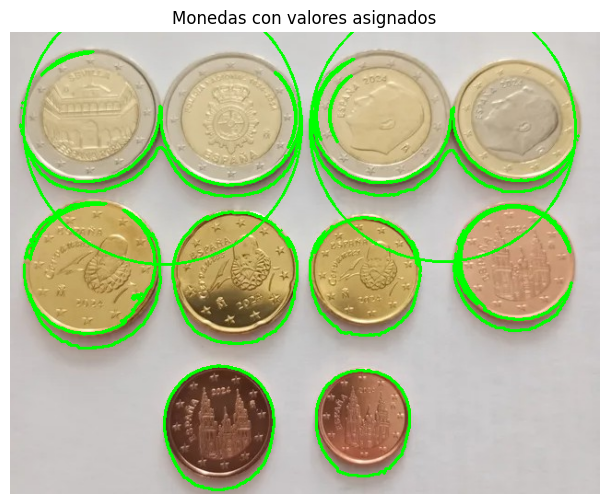

In [167]:
# --- Carga imagen ---
#img = cv2.imread('Monedas.jpg')
#img = cv2.imread('monedas2.webp')
#img = cv2.imread('monedas3.jpg')
img = cv2.imread('monedas4.jpg')
#img = cv2.imread('monedasjuntas.jpg') mal
#img = cv2.imread('monedas5.webp') mal
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Umbralizado binario invertido ---
umbral = 150
_, img_th1 = cv2.threshold(img_gris, umbral, 255, cv2.THRESH_BINARY_INV)

# --- Obtiene contornos externos ---
contornos, _ = cv2.findContours(img_th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Filtra contornos internos de monedas bimetálicas ---
contornos_filtrados = []
for i, c1 in enumerate(contornos):
    (x1, y1), r1 = cv2.minEnclosingCircle(c1)
    es_interno = False
    for j, c2 in enumerate(contornos):
        if i == j:
            continue
        (x2, y2), r2 = cv2.minEnclosingCircle(c2)
        # Si el contorno c1 está completamente dentro de c2
        dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        if dist + r1 < r2:
            es_interno = True
            break
    if not es_interno:
        contornos_filtrados.append(c1)

# --- Dibuja contornos externos sobre imagen ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos_filtrados, -1, (0,255,0), 2)

# --- Calcula radios y centros de los contornos ---
circulos = []
for c in contornos_filtrados:
    (x, y), r = cv2.minEnclosingCircle(c)  # mínimo círculo que encierra contorno
    #if r > 30:  # filtrar ruidos muy pequeños
    circulos.append((x, y, r))

# --- Ordena círculos por radio descendente ---
circulos = sorted(circulos, key=lambda x: x[2], reverse=True)

# --- Diámetros de referencia en mm ---
diametros_mm = {
    2.00: 25.75,
    1.00: 23.25,
    0.50: 24.25,
    0.20: 22.25,
    0.10: 19.75,
    0.05: 21.25,
    0.02: 18.75,
    0.01: 16.25
}

# --- Asigna valores relativos a la moneda más grande (2 €) ---
r_max = circulos[0][2]  # asumimos que la primera es la moneda de 2€
umbral_proporcion = 0.6  # descarta radios menores al 60% del mayor - 16.25 / 25.75 = 0.63
circulos_filtrados = [(x, y, r) for x, y, r in circulos if r >= r_max * umbral_proporcion]

monedas_detectadas = []

for x, y, r in circulos_filtrados:
    # Proporción respecto al radio máximo
    propor = r / r_max
    # Inicializamos con valor aproximado
    valor = 0.01
    min_dif = float('inf')
    # Buscamos la moneda más cercana según diámetro proporcional
    for v, d in diametros_mm.items():
        # Relaciona diámetro con proporción
        d_rel = d / diametros_mm[2.00]
        dif = abs(propor - d_rel)
        if dif < min_dif:
            min_dif = dif
            valor = v
    monedas_detectadas.append((x, y, r, valor))

# --- Dibuja círculos y valores sobre la imagen ---
for x, y, r, valor in monedas_detectadas:
    cv2.circle(img_rgb, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(img_rgb, f"{valor:.2f} €",
                (int(x - r), int(y - r - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# --- Muestra resultado ---
plt.figure(figsize=(8,6))
plt.axis("off")
plt.imshow(img_rgb)
plt.title("Monedas con valores asignados")
plt.show()


Cargamos muestras de entrenamiento

In [168]:
def preprocesar_imagen(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Convertir a escala de grises
    imagen_norm = cv2.normalize(imagen_gris, None, 0, 255, cv2.NORM_MINMAX) # Normalizar entre 0 y 255
    imagen_suave = cv2.GaussianBlur(imagen_norm, (15, 15), 0) # Suavizar
    return imagen_suave

def recortar_imagen(imagen, recorte):
    return imagen[recorte]

def segmentar_imagen(imagen):
    umbral = cv2.adaptiveThreshold(
        imagen,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,   # Invertido: fondo negro, objetos blancos
        15,                      # Vecindad más pequeña, más sensible a detalle
        3                        # Eliminar partículas
    )
    return umbral

def extraer_caracteristicas_basicas(img, img_segmentada):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_uint8 = (img_segmentada > 0).astype(np.uint8) * 255 # Máscara binaria
    color_promedio = cv2.mean(img_rgb, mask=mask_uint8)[:3]  # (R, G, B)

    # Forma
    contornos, _ = cv2.findContours(img_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas, circularidades = [], []
    for c in contornos:
        area = cv2.contourArea(c)
        if area < 50:
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = 4 * np.pi * area / (perimetro ** 2) if perimetro > 0 else 0
        areas.append(area)
        circularidades.append(circularidad)

    area_media = np.mean(areas) if areas else 0
    circ_media = np.mean(circularidades) if circularidades else 0

    return {
        "area_media": round(area_media, 2),
        "circularidad_media": round(circ_media, 3),
        "color_R": round(color_promedio[0], 1),
        "color_G": round(color_promedio[1], 1),
        "color_B": round(color_promedio[2], 1)
    }

Text(0.5, 1.0, 'Alquitrán')

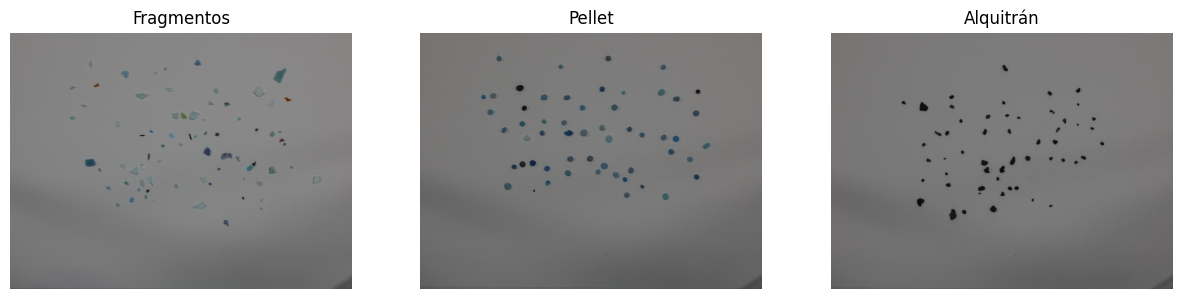

In [169]:
#Se cargan las imágenes
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
alqui = cv2.imread('tar-03-olympus-10-01-2020.JPG')

#Mostramos
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.axis("off")
plt.imshow(frag)
plt.title('Fragmentos')

plt.subplot(132)
plt.axis("off")
plt.imshow(pellet)
plt.title('Pellet')

plt.subplot(133)
plt.axis("off")
plt.imshow(alqui)
plt.title('Alquitrán')

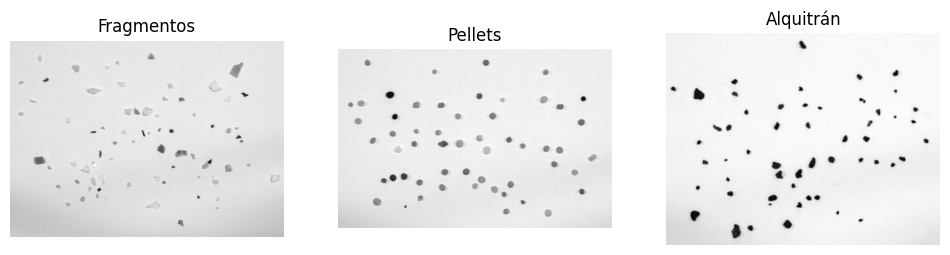

In [170]:
# Secciones sobre las que trabajar
recorte_frag = (slice(200, 2750), slice(700, 4250))
recorte_pellets = (slice(175, 2400), slice(700, 4100))
recorte_tar = (slice(350, 2600), slice(900, 3800))

# Recortar imágenes
frag = recortar_imagen(frag, recorte_frag)
pellet = recortar_imagen(pellet, recorte_pellets)
alqui = recortar_imagen(alqui, recorte_tar)

# Normalizar las imágenes
frag_gris = preprocesar_imagen(frag)
pellet_gris = preprocesar_imagen(pellet)
alqui_gris = preprocesar_imagen(alqui)

#Mostrar las imágenes preprocesadas
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Fragmentos')
plt.axis("off")
plt.imshow(frag_gris, cmap='gray')

plt.subplot(132)
plt.title('Pellets')
plt.axis("off")
plt.imshow(pellet_gris, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_gris, cmap='gray')
plt.show()

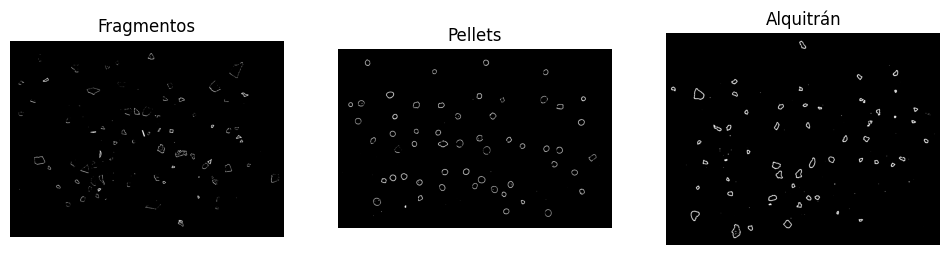

In [171]:
frag_segmentada = segmentar_imagen(frag_gris)
pellet_segmentada = segmentar_imagen(pellet_gris)
alqui_segmentada = segmentar_imagen(alqui_gris)

#Mostrar imágenes segmentadas
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Fragmentos')
plt.axis("off")
plt.imshow(frag_segmentada, cmap='gray')

plt.subplot(132)
plt.title('Pellets')
plt.axis("off")
plt.imshow(pellet_segmentada, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_segmentada, cmap='gray')
plt.show()

In [172]:
frag_features = extraer_caracteristicas_basicas(frag, frag_segmentada)
pellet_features = extraer_caracteristicas_basicas(pellet, pellet_segmentada)
alqui_features = extraer_caracteristicas_basicas(alqui, alqui_segmentada)

print("Fragmentos:", frag_features)
print("Pellets:", pellet_features)
print("Alquitrán:", alqui_features)

Fragmentos: {'area_media': np.float64(395.79), 'circularidad_media': np.float64(0.252), 'color_R': 87.5, 'color_G': 85.1, 'color_B': 77.7}
Pellets: {'area_media': np.float64(1845.03), 'circularidad_media': np.float64(0.402), 'color_R': 77.5, 'color_G': 68.6, 'color_B': 55.6}
Alquitrán: {'area_media': np.float64(2021.87), 'circularidad_media': np.float64(0.687), 'color_R': 30.0, 'color_G': 29.1, 'color_B': 30.6}


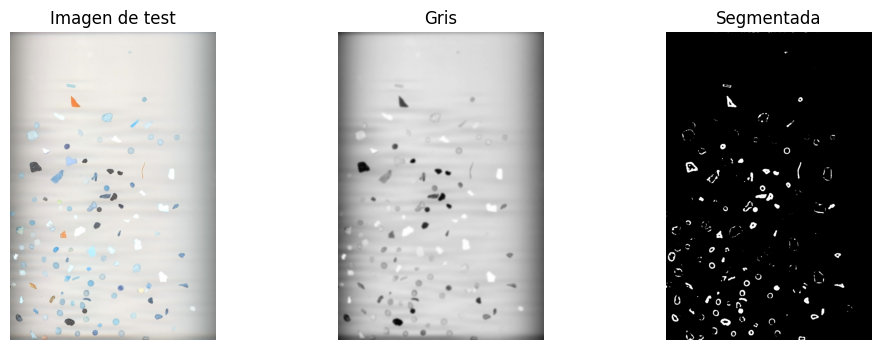

In [179]:
#Mostrar imágenes
plt.figure(figsize=(12, 4))
imagen_test = cv2.imread('MPs_test.jpg')
plt.subplot(131)
plt.axis("off")
plt.imshow(imagen_test) 
plt.title('Imagen de test')

test_gris = preprocesar_imagen(imagen_test)
plt.subplot(132)
plt.title('Gris')
plt.axis("off")
plt.imshow(test_gris, cmap='gray')

test_segmentada = segmentar_imagen(test_gris)
plt.subplot(133)
plt.title('Segmentada')
plt.axis("off")
plt.imshow(test_segmentada, cmap='gray')
plt.show()

In [174]:
def clasificar(imagen_segmentada, imagen_color):
    contornos, _ = cv2.findContours(imagen_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clasificaciones = {'fragmentos': 0, 'pellets': 0, 'alquitran': 0}

    for c in contornos:
        area = cv2.contourArea(c)
        if area < 5:  # descartar ruido
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0

        # Color promedio dentro del objeto
        mask = np.zeros(imagen_segmentada.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        color_prom = cv2.mean(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB), mask=mask.astype(np.uint8))[:3]

        # Clasificación combinada
        if color_prom[0] < 122:  # oscuro → alquitrán
            clasificaciones['alquitran'] += 1
        elif circularidad > 0.5:  # redondez → pellet
            clasificaciones['pellets'] += 1
        else:  # lo demás → fragmentos
            clasificaciones['fragmentos'] += 1

    return clasificaciones

test_clasif = clasificar(test_segmentada, imagen_test)   # <- Aquí añades la imagen de test

print("Clasificación Test (imagen completa):", test_clasif)

Clasificación Test (imagen completa): {'fragmentos': 98, 'pellets': 53, 'alquitran': 13}


Obtener coordenadas de predicciones

In [230]:
def clasificar_coordenadas(imagen_segmentada, imagen_color, dist_min=10):
    contornos, _ = cv2.findContours(imagen_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    predicciones = []

    for c in contornos:
        area = cv2.contourArea(c)
        if area < 2:
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0
        x, y, w, h = cv2.boundingRect(c)

        # Color promedio dentro del objeto
        mask = np.zeros(imagen_segmentada.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        color_prom = cv2.mean(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB), mask=mask.astype(np.uint8))[:3]

        # Clasificación heurística
        if color_prom[0] < 120:  # oscuro → alquitrán
            clase = "TAR"
        elif circularidad > 0.5:  # redondo → pellet
            clase = "PEL"
        else:
            clase = "FRA"

        predicciones.append({
            "x_min": x, "y_min": y, "x_max": x + w, "y_max": y + h,
            "label": clase
        })

    # --- FUSIONAR CAJAS CERCANAS ---
    fusionadas = []
    for box in predicciones:
        x1, y1, x2, y2, label = box["x_min"], box["y_min"], box["x_max"], box["y_max"], box["label"]
        merged = False
        for f in fusionadas:
            # Comprobar si se solapan o están cerca y son de la misma clase
            if box["label"] == f["label"] and not (x2 < f["x_min"] - dist_min or x1 > f["x_max"] + dist_min or
                                      y2 < f["y_min"] - dist_min or y1 > f["y_max"] + dist_min):
                # Fusionar: ampliar los límites
                f["x_min"] = min(f["x_min"], x1)
                f["y_min"] = min(f["y_min"], y1)
                f["x_max"] = max(f["x_max"], x2)
                f["y_max"] = max(f["y_max"], y2)
                merged = True
                break
        if not merged:
            fusionadas.append(box)

    return fusionadas

predicciones = clasificar_coordenadas(test_segmentada, imagen_test)

Comparativa de imagen con anotaciones vs predicciones

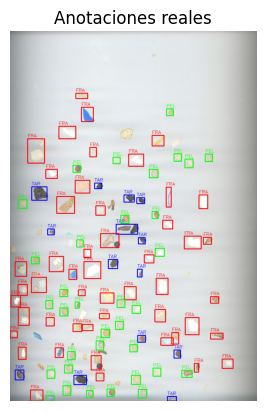

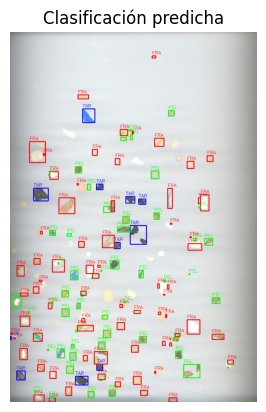

In [231]:
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# --- FUNCIÓN AUXILIAR PARA DIBUJAR CAJAS ---
def dibujar_cajas(img, cajas, titulo=""):
    for c in cajas:
        etiqueta = c["label"]
        x_min, y_min, x_max, y_max = int(c["x_min"]), int(c["y_min"]), int(c["x_max"]), int(c["y_max"])
        color = colores.get(etiqueta, (0, 0, 0))
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()


# --- LEE ANOTACIONES REALES ---
csv_file = "MPs_test_bbs.csv"
anotaciones = []
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        anotaciones.append({
            "x_min": int(row["x_min"]),
            "y_min": int(row["y_min"]),
            "x_max": int(row["x_max"]),
            "y_max": int(row["y_max"]),
            "label": row["label"]
        })

# --- DIBUJAR RESULTADOS ---
dibujar_cajas(imagen_test.copy(), anotaciones, "Anotaciones reales")
dibujar_cajas(imagen_test.copy(), predicciones, "Clasificación predicha")

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.


MÉTRICAS:
Tasa de acierto  = 0.604
Precisión = 0.631


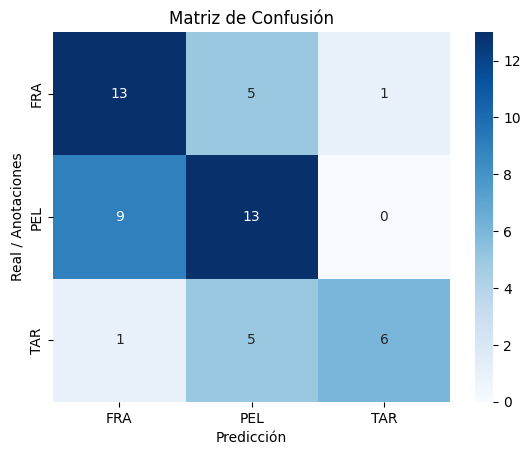

In [236]:
# --- FUNCIÓN PARA CALCULAR INTERSECCIÓN ---
def iou(boxA, boxB):
    xA = max(boxA["x_min"], boxB["x_min"])
    yA = max(boxA["y_min"], boxB["y_min"])
    xB = min(boxA["x_max"], boxB["x_max"])
    yB = min(boxA["y_max"], boxB["y_max"])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA["x_max"] - boxA["x_min"]) * (boxA["y_max"] - boxA["y_min"])
    boxBArea = (boxB["x_max"] - boxB["x_min"]) * (boxB["y_max"] - boxB["y_min"])

    return interArea / float(boxAArea + boxBArea - interArea)

# --- EMPAREJAR POR INTERSECCIÓN ---
y_true, y_pred = [], []
iou_threshold = 0.5  # area de intersección

for gt in anotaciones:
    mejor_iou = 0
    mejor_pred = None

    for pred in predicciones:
        iou_val = iou(gt, pred)
        if iou_val > mejor_iou:
            mejor_iou = iou_val
            mejor_pred = pred

    # Solo cuenta si realmente se solapan
    if mejor_iou >= iou_threshold and mejor_pred is not None:
        y_true.append(gt["label"])
        y_pred.append(mejor_pred["label"])

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)

print("\nMÉTRICAS:")
print(f"Tasa de acierto  = {accuracy:.3f}")
print(f"Precisión = {precision:.3f}")

# --- MATRIZ DE CONFUSIÓN ---
labels = ["FRA", "PEL", "TAR"]
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real / Anotaciones")
plt.title("Matriz de Confusión")
plt.show()
